# GBP/USD Exchange Rate during 2017 UK Election Night - Under Construction



In [130]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm
from statsmodels.regression.linear_model import RegressionResults
import random

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab

import tweepy

import json

import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [2]:
CONSUMER_KEY = '4BByuBKYk19fpSl5iMIkju3c0'
CONSUMER_SECRET = '2EK91aT0s7uMJ1oWECBRUwkXrxGykigrsmtqtOIAvFBPXiucQq'
ACCESS_TOKEN = '892729320736739328-E30nIY5dacqxeugxPoe3TXB2fIjITZB'
ACCESS_TOKEN_SECRET = 'WMViNA7y1d1trkb5nt7L5dOAHdScmYBMHm33sLeUVZrWT'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

tweets_raw = api.user_timeline(screen_name = 'bbcelection', count = 200, include_rts = False)
for i in range(0,5):
    oldest=tweets_raw[-1].id
    new_tweets = api.user_timeline(screen_name = 'bbcelection',count=200,max_id=oldest)
    tweets_raw.extend(new_tweets)

data = [[tw.created_at.year, tw.created_at.month, tw.created_at.day,"%s.%s"%(tw.created_at.hour, tw.created_at.minute), tw.id_str, tw.text.encode("utf8")] for tw in tweets_raw ]
tweets=pd.DataFrame(data, columns=['year','month','date','time','tweet_id','tweet'])
tweets = tweets[tweets.year==2017]


In [176]:
# Wikipedia data
UKpoll = pd.read_csv('data/UK2017Poll.txt', sep='\t', header=0)
UKpoll.columns=['ID','Con_poll', 'Lab_poll', 'Lib_poll','SNP_poll','Pla_poll','Greens_poll',\
                'UKIP_poll', 'Other_poll', 'Seat','Region','2015']
results = pd.read_csv("data/result.csv")
results

ID               Constituency Cnty  Rgn Last Election Party  \
0    W07000049                   Aberavon  WGM  WLS           Lab   Lab   
1    W07000058                  Aberconwy  CON  WLS           Con   Con   
2    S14000001             Aberdeen North  SCT  SCT           SNP   SNP   
3    S14000002             Aberdeen South  SCT  SCT           SNP   Con   
4    S14000003         Airdrie and Shotts  SCT  SCT           SNP   SNP   
5    E14000530                  Aldershot  HAM   SE           Con   Con   
6    E14000531        Aldridge-Brownhills  WMD   WM           Con   Con   
7    E14000532   Altrincham and Sale West  GTM   NW           Con   Con   
8    W07000043           Alyn and Deeside  CON  WLS           Lab   Lab   
9    E14000533               Amber Valley  DBY   EM           Con   Con   
10   S14000004                      Angus  SCT  SCT           SNP   Con   
11   W07000057                      Arfon  GWN  WLS            PC    PC   
12   S14000005            Argyll and Bute  SCT  SCT           SNP   SNP   
13   E14000534    Arundel and South Downs  WSX   SE           Con   Con   
14   E14000535                   Ashfield  NTT   EM           Lab   Lab   
15   E14000536                    Ashford  KEN   SE           Con   Con   
16   E14000537          Ashton-under-Lyne  GTM   NW           Lab   Lab   
17   E14000538                  Aylesbury  BKM   SE           Con   Con   
18   S14000006   Ayr, Carrick and Cumnock  SCT  SCT           SNP   Con   
19   E14000539                    Banbury  OXF   SE           Con   Con   
20   S14000007           Banff and Buchan  SCT  SCT           SNP   Con   
21   E14000540                    Barking  LND  LND           Lab   Lab   
22   E14000541           Barnsley Central  SYK  YTH           Lab   Lab   
23   E14000542              Barnsley East  SYK  YTH           Lab   Lab   
24   E14000543         Barrow and Furness  CMA   NW           Lab   Lab   
25   E14000544    Basildon and Billericay  ESS    E           Con   Con   
26   E14000545                Basingstoke  HAM   SE           Con   Con   
27   E14000546                  Bassetlaw  NTT   EM           Lab   Lab   
28   E14000547                       Bath  AVN   SW           Con    LD   
29   E14000548            Batley and Spen  WYK  YTH           Lab   Lab   
..         ...                        ...  ...  ...           ...   ...   
620  E14001035        West Worcestershire  HWR   WM           Con   Con   
621  E14001036          Westminster North  LND  LND           Lab   Lab   
622  E14001037   Westmorland and Lonsdale  CMA   NW            LD    LD   
623  E14001038          Weston-Super-Mare  AVN   SW           Con   Con   
624  E14001039                      Wigan  GTM   NW           Lab   Lab   
625  E14001040                  Wimbledon  LND  LND           Con   Con   
626  E14001041                 Winchester  HAM   SE           Con   Con   
627  E14001042                    Windsor  BRK   SE           Con   Con   
628  E14001043               Wirral South  MSY   NW           Lab   Lab   
629  E14001044                Wirral West  MSY   NW           Lab   Lab   
630  E14001045                     Witham  ESS    E           Con   Con   
631  E14001046                     Witney  OXF   SE           Con   Con   
632  E14001047                     Woking  SRY   SE           Con   Con   
633  E14001048                  Wokingham  BRK   SE           Con   Con   
634  E14001049   Wolverhampton North East  WMD   WM           Lab   Lab   
635  E14001050   Wolverhampton South East  WMD   WM           Lab   Lab   
636  E14001051   Wolverhampton South West  WMD   WM           Lab   Lab   
637  E14001052                  Worcester  HWR   WM           Con   Con   
638  E14001053                 Workington  CMA   NW           Lab   Lab   
639  E14001054   Worsley and Eccles South  GTM   NW           Lab   Lab   
640  E14001055              Worthing West  WSX   SE           Con   Con   
641  W07000044                    Wre

In [4]:
tweets.tweet=tweets.tweet.astype(str)
tweets_cleaned = tweets[tweets.tweet.str.contains('#GE2017')]
tweets_cleaned['time_full'] = tweets_cleaned["year"].map(str)+ "/"+ tweets_cleaned["month"].map(str) + \
    "/"+ tweets_cleaned["date"].map(str)  + "/"+ tweets_cleaned["time"].map(str) 

## Merging result data with time

In [5]:
tweets_cleaned['Constituency']=np.nan
for i in range(len(tweets)):
    tweets_cleaned.Constituency[i] = tweets_cleaned.tweet[i][tweets_cleaned.tweet[i].find("\'")+1:tweets_cleaned.tweet[i].find(":")]
tweets_cleaned.to_csv('data/tweets.csv',sep=',')



C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [177]:
#manual matching
tw_matched = pd.read_csv('data/tweets_matched.csv')
tw_matched = tw_matched.dropna(axis=0, how='any')
tw_matched = tw_matched.drop_duplicates(subset='ID', keep='last')
tw_matched.index = np.arange(len(tw_matched))
tw_matched.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 642 entries, 0 to 641
Data columns (total 9 columns):
year            642 non-null int64
month           642 non-null int64
date            642 non-null int64
time            642 non-null float64
tweet_id        642 non-null float64
tweet           642 non-null object
time_full       642 non-null object
Constituency    642 non-null object
ID              642 non-null object
dtypes: float64(2), int64(3), object(4)
memory usage: 50.2+ KB


In [178]:
results = results.merge( tw_matched[['ID','time_full']], how='left', left_on = 'ID', right_on='ID')
results
results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']]=(results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']].T/results['Total']).T
results['time']=np.nan
for i in range(0,len(results)):
    try:
        results['time'].loc[i]= datetime.strptime(results.time_full[i],'%Y/%m/%d/%H.%M')
    except:
        results['time'].loc[i] = np.nan

C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


## Merging poll with result

In [184]:
full_table = pd.merge(results, UKpoll,  how='left', left_on='ID', right_on = 'ID')
full_table = full_table.sort_values(by='time').reset_index(drop=True)


## Other factors
taken from UK sensus 

In [201]:
xl = pd.ExcelFile("data/Wages.xlsx")
wages=xl.parse("Data")
wages.head()
full_table = pd.merge(full_table, wages[['ONSConstID','WageMedianConst']],  how='left', left_on='ID', right_on = 'ONSConstID')

xl = pd.ExcelFile("data/Business-numbers.xlsx")
business=xl.parse("Data")
#full_table = pd.merge(full_table, business,  how='left', left_on='Constituency', right_on = 'ConstituencyName')

xl = pd.ExcelFile("data/Population-by-age.xlsx")
population=xl.parse("Data")
full_table = pd.merge(full_table, population[['ONSConstID','Pop65ConstRate']],  how='left', left_on='ID', right_on = 'ONSConstID')

full_table['islab'] = (full_table['Last Election']=='Lab').astype(int)
full_table['iscon'] = (full_table['Last Election']=='Con').astype(int)
full_table['islib'] = (full_table['Last Election']=='LD').astype(int)
full_table['issnp'] = (full_table['Last Election']=='SNP').astype(int)


## Analysis

In [371]:
columns = ['time', 'Constituency','low', 'ave', 'high']
index= full_table.index
pred=pd.DataFrame(index=index, columns=columns)

parameters_con = np.empty((650,7))
stderr_con = np.empty((650,7))
parameters_lab = np.empty((650,7))
stderr_lab = np.empty((650,7))
parameters_snp = np.empty((650,4))
stderr_snp = np.empty((650,4))

sim_num = 50
for i in range(10,len(full_table)-14):
    
    #labour regression
   # data_lab=full_table[['Lab_poll','Lab[c]','Total','Last Election','WageMedianConst','Pop65ConstRate']]
    data_lab= pd.concat([full_table['Lab_poll'], full_table['WageMedianConst'],full_table['islab'],\
                      full_table['Pop65ConstRate'],full_table['islab']*full_table['WageMedianConst'],\
                     full_table['islab']*full_table['Pop65ConstRate'],full_table['Lab[c]']], axis=1)
    X_lab = data_lab.drop('Lab[c]',axis=1)[0:i]
    Y_lab=data_lab['Lab[c]'][0:i]
    X_lab=sm.add_constant(X_lab, has_constant='add')
    model_lab = sm.OLS(Y_lab, X_lab,missing = 'drop').fit()
    
    parameters_lab[i,:]=model_lab.params
    stderr_lab[i,:]=model_lab.bse
    
    #Conservatives regression
    #data_con=full_table[['Con_poll','Con[b]','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_con=pd.concat([full_table['Con_poll'], full_table['WageMedianConst'], full_table['iscon'],
                     full_table['Pop65ConstRate'],  full_table['iscon']*full_table['WageMedianConst'],
                      full_table['iscon']*full_table['Pop65ConstRate'],full_table['Con[b]']], axis=1)
    X_con = data_con.drop(['Con[b]'], axis = 1)[0:i]
    Y_con=data_con['Con[b]'][0:i]
    X_con=sm.add_constant(X_con, has_constant='add')
    model_con = sm.OLS(Y_con, X_con,missing = 'drop').fit()
    
    parameters_con[i,:]=model_con.params
    stderr_con[i,:]=model_con.bse
    
    #Liberal Regression
    #data_lib=full_table[['Lib_poll','LD','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    #data_lib=pd.concat([full_table['Lib_poll'], full_table['WageMedianConst'],full_table['islib'],
    #                 full_table['Pop65ConstRate'],full_table['islib']* full_table['WageMedianConst'],
    #                full_table['islib']*full_table['Pop65ConstRate'],full_table['LD']], axis=1)
    #X_lib = data_lib.drop(['LD'],axis=1)[0:i]
    #Y_lib=data_lib['LD'][0:i]
    #X_lib=sm.add_constant(X_lib, has_constant='add')
    #model_lib = sm.OLS(Y_lib, X_lib,missing = 'drop').fit()
    

    #SNP Regression
    #SNP has no votes and poll in many regions, assign 0 to model in this case
    #full_table['SNP']=full_table['SNP'].fillna(0)
    #data_snp=full_table[['SNP_poll','SNP','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_snp=pd.concat([full_table['SNP_poll'], full_table['WageMedianConst'],
                     full_table['Pop65ConstRate'], full_table['SNP']], axis=1)
    X_snp = data_snp.drop(['SNP'],axis = 1)[0:i]
    Y_snp=data_snp['SNP'][0:i]
    X_snp=sm.add_constant(X_snp, has_constant='add')
    try:
        model_snp = sm.OLS(Y_snp, X_snp,missing = 'drop').fit()
        parameters_snp[i,:]
        stderr_snp[i,:]=model_snp.bse
    except:
        model_snp = 0
        

    

    predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
    predict_lab=predict_lab[np.isfinite(predict_lab['Lab_poll'])]
    result = np.zeros([sim_num, len(predict_lab)])
    
    #Sampling the regression parameters to generate predicted outcome
    for j in range(0, sim_num):
        
        #Labour
        param_lab = np.random.multivariate_normal(np.asarray(model_lab.params), RegressionResults.cov_params(model_lab), sim_num)
        predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
        
        
        #fill NaN with mean
        #predict_lab = predict_lab.fillna(predict_lab.mean())
        predict_lab=predict_lab[np.isfinite(predict_lab['Lab_poll'])]
        
        result_temp =  np.matmul(param_lab,np.array(predict_lab).T)
        #result_lab = np.random.normal(result_temp,np.std(model_lab.resid))
        err_dev = np.std(model_lab.resid)*(np.random.chisquare(len(model_lab.resid)-7)*1./(len(model_lab.resid)-7))**0.5
        result_lab = np.random.normal(result_temp,err_dev)
        
        
        #Conservative
        param_con = np.random.multivariate_normal(np.asarray(model_con.params), RegressionResults.cov_params(model_con), sim_num)
        predict_con=sm.add_constant(data_con.drop(['Con[b]'], axis = 1)[i:], has_constant='add')
        
        
        #predict_con = predict_con.fillna(predict_con.mean())
        predict_con = predict_con[np.isfinite(predict_con['Con_poll'])]
        
        result_temp = np.matmul(param_con,np.array(predict_con).T)
        #result_con = np.random.normal(result_temp,np.std(model_con.resid))
        err_dev = np.std(model_con.resid)*(np.random.chisquare(len(model_con.resid)-7)*1./(len(model_con.resid)-7))**0.5
        result_con = np.random.normal(result_temp,err_dev)
        
        
        #Liberal
        #param_lib = np.random.multivariate_normal(np.asarray(model_lib.params), RegressionResults.cov_params(model_lib), sim_num)
        #predict_lib=sm.add_constant(data_lib.drop(['LD'],axis=1)[i:], has_constant='add')
        
        
        #predict_lib = predict_lib.fillna(predict_lib.mean())
        
        #result_temp =  np.matmul(param_lib,np.array(predict_lib).T)
        #err_dev = np.std(model_lib.resid)*(np.random.chisquare(len(model_lib.resid)-7)*1./(len(model_lib.resid)-2))**0.5
        #result_lib = np.random.normal(result_temp,err_dev)
        
        
        #SNP
        predict_snp=sm.add_constant(data_snp.drop(['SNP'],axis = 1)[i:], has_constant='add')
        predict_snp = predict_snp[np.isfinite(predict_snp['SNP_poll'])]
        if not model_snp==0 and len(model_snp.resid)>8:
            param_snp = np.random.multivariate_normal(np.asarray(model_snp.params), RegressionResults.cov_params(model_snp), sim_num)

            #predict_snp = predict_snp.fillna(predict_snp.mean())

            result_temp =  np.matmul(param_snp,np.array(predict_snp).T)
            #result_snp = np.random.normal(result_temp,np.std(model_snp.resid))
            err_dev = np.std(model_snp.resid)*(np.random.chisquare(len(model_snp.resid)-4)*1./(len(model_snp.resid)-4))**0.5
            result_snp = np.random.normal(result_temp,err_dev)
            #if the poll is 0, the resulting simulated data should also be 0
            ind=np.where(predict_snp.SNP_poll==0)
            result_snp[:,ind]=0
            
        else:
            #no data
            result_snp = np.tile(predict_snp['SNP_poll'],(sim_num,1))/100
        
        #result_pla = np.nan_to_num(np.tile(full_table['Pla_poll'][i:],(sim_num,1)))/100
        #result_ukip = np.nan_to_num(np.tile(full_table['UKIP_poll'][i:],(sim_num,1)))/100
        other = 1-result_con-result_lab-result_snp
        
        result_temp = (result_con>result_lab) & (result_con>result_snp) & (result_con>other)  
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=len(full_table.Party[0:i][full_table.Party=='Con'])+ np.count_nonzero(result, axis=1) 
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=full_table.time[i]
    pred.Constituency[i]=full_table.ID[i]
    pred.low[i]=np.mean(EEV)-np.std(EEV)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.mean(EEV)+np.std(EEV)

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: RuntimeWarning: invalid value encountered in greater
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1353: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


In [262]:
pred[200:250]

time Constituency      low      ave     high
200  2017-06-09 04:03:00    E14000682  317.769  319.626  321.482
201  2017-06-09 04:08:00    E14000655  317.834  319.632   321.43
202  2017-06-09 04:11:00    E14000993  317.739   319.56  321.382
203  2017-06-09 04:13:00    E14000797  317.773  319.624  321.475
204  2017-06-09 04:14:00    E14000971  317.806  319.608  321.411
205  2017-06-09 04:15:00    E14001041  317.072  318.858  320.644
206  2017-06-09 04:16:00    E14000586  317.945  319.688   321.43
207  2017-06-09 04:17:00    E14000709  318.001  319.738  321.475
208  2017-06-09 04:18:00    E14000623  318.037  319.779  321.521
209  2017-06-09 04:19:00    E14000918  318.032  319.765  321.498
210  2017-06-09 04:20:00    E14001014  318.014  319.745  321.475
211  2017-06-09 04:21:00    E14000835  318.066  319.745  321.424
212  2017-06-09 04:22:00    W07000047  318.067  319.748  321.429
213  2017-06-09 04:23:00    E14001013  317.386  319.268  321.151
214  2017-06-09 04:24:00    E14000573  317.347  319.273  321.199
215  2017-06-09 04:26:00    E14000764  317.236  319.169  321.102
216  2017-06-09 04:27:00    E14000753  317.257  319.156  321.055
217  2017-06-09 04:28:00    S14000042  316.622  318.452  320.281
218  2017-06-09 04:29:00    E14000740  316.648  318.442  320.235
219  2017-06-09 04:30:00    E14000783  317.229   318.94  320.651
220  2017-06-09 04:32:00    E14000755  317.214  318.891  320.568
221  2017-06-09 04:33:00    E14000919  317.212  318.921   320.63
222  2017-06-09 04:35:00    E14000844  317.201  318.908  320.614
223  2017-06-09 04:36:00    E14000656  317.212  318.925  320.638
224  2017-06-09 04:37:00    S14000013  317.299  318.931  320.564
225  2017-06-09 04:38:00    E14000721  317.384  319.036  320.689
226  2017-06-09 04:39:00    S14000033   317.39  319.041  320.692
227  2017-06-09 04:40:00    N06000010   317.35  319.044  320.738
228  2017-06-09 04:41:00    E14001002  317.334  319.035  320.737
229  2017-06-09 04:42:00    E14000673  316.446  318.096  319.745
230  2017-06-09 04:44:00    E14000553  316.401   318.07  319.739
231  2017-06-09 04:47:00    E14000727  316.433  318.075  319.717
232  2017-06-09 04:49:00    E14000545  316.344  318.044  319.744
233  2017-06-09 04:50:00    E14000636  316.383  318.078  319.772
234  2017-06-09 04:53:00    S14000023  316.383   318.07  319.756
235  2017-06-09 04:54:00    E14000955  282.755  289.689  296.624
236  2017-06-09 04:55:00    E14000872  283.765   290.73  297.695
237  2017-06-09 04:56:00    W07000079   284.65  291.727  298.803
238  2017-06-09 04:57:00    E14001057  284.765  291.702  298.638
239  2017-06-09 04:59:00    E14000752  286.848  293.326  299.803
240  2017-06-09 05:00:00    E14000743  287.891  294.492  301.093
241  2017-06-09 05:01:00    E14000945  289.285  295.396  301.508
242  2017-06-09 05:02:00    E14000537  290.245  296.042  301.839
243  2017-06-09 05:04:00    E14000548  290.216  296.488  302.759
244  2017-06-09 05:05:00    E14000665   291.06  296.822  302.584
245  2017-06-09 05:06:00    E14000663  292.144  297.952  303.759
246  2017-06-09 05:07:00    E14000952  292.229  297.778  303.327
247  2017-06-09 05:08:00    E14000678  294.087  299.201  304.315
248  2017-06-09 05:09:00    E14000551  295.139  300.012  304.885
249  2017-06-09 05:10:00    E14000956  296.268  300.918  305.567

In [247]:
result_temp.shape

(50, 619)

In [20]:
fx = pd.read_csv('data/FX data.csv',header=None,sep='\;')

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[5], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:4].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]
fx['time'] = [datetime.strptime(v, '%Y%m%d %H%M%S') for v in fx['time']]

#change time to UTC to match twitter
fx['time'] = [v + timedelta(hours=5) for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:5],1)


C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


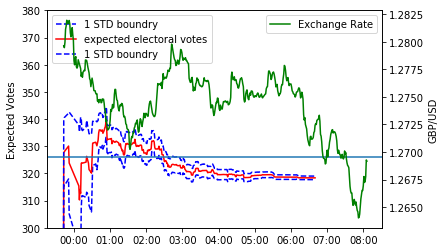

In [363]:
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
pylab.legend(loc='upper left')
plt.axhline(y=326)
ax1.set_ylim([300,380])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('GBP/USD')
plt.xlabel('UTC Time')
pylab.legend(loc='upper right')


plt.show()


In [145]:

i=10
data_lab= pd.concat([full_table['Lab_poll'], full_table['WageMedianConst'],\
                      full_table['Pop65ConstRate'],full_table['islab']*full_table['WageMedianConst'],\
                     full_table['islab']*full_table['Pop65ConstRate'],full_table['Lab[c]']], axis=1)
X_lab = data_lab.drop('Lab[c]',axis=1)[0:i]
Y_lab=data_lab['Lab[c]'][0:i]
X_lab=sm.add_constant(X_lab, has_constant='add')
model_lab = sm.RLM(Y_lab, X_lab,missing = 'drop').fit()

In [266]:
full_table[full_table.ID = 'E14000955']

SyntaxError: invalid syntax (<ipython-input-266-d17f315749a4>, line 1)

In [35]:
full_table[full_table['time']==np.nan]

Empty DataFrame
Columns: [ID, Constituency, Cnty, Rgn, Last Election, Party, Votes, Share, Majrty, turnout, Con[b], Lab[c], LD, SNP, UKIP, Grn[d], DUP, SF, PC, SDLP, UUP, APNI, Other[e], Total, time_full, time, Con_poll, Lab_poll, Lib_poll, SNP_poll, Pla_poll, Greens_poll, UKIP_poll, Other_poll, Seat, Region, 2015, ONSConstID_x, WageMedianConst, ONSConstID_y, Pop65ConstRate, islab, iscon, islib, issnp]
Index: []

[0 rows x 45 columns]

In [67]:

parameters

array([[  1.09962649e-311,   1.09961201e-311,   2.60000000e+001,
          5.50000000e+001,   2.80000000e+001,   3.10000000e+001],
       [  6.40000000e+001,   4.90000000e+001,   2.60000000e+001,
          5.90000000e+001,   5.40000000e+001,   3.70000000e+001],
       [  2.80000000e+001,   4.10000000e+001,   2.60000000e+001,
          1.40000000e+001,   3.90000000e+001,   4.90000000e+001],
       ..., 
       [  4.81136809e-001,   4.64353637e-001,   4.31811970e-001,
          4.95388475e-001,   5.54129716e-001,   4.21775215e-001],
       [  4.70314573e-001,   2.97107040e-001,   2.09462858e-001,
          5.69217290e-001,   3.00237848e-001,   5.07125471e-001],
       [  4.33727516e-001,   6.09118565e-001,   2.16145211e-001,
          2.37828832e-001,   2.87070954e-001,   6.13787507e-001]])

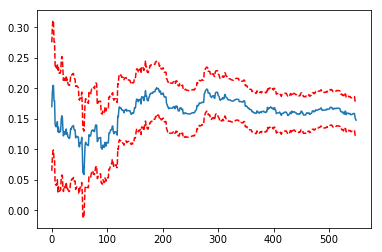

In [373]:

plt.plot(parameters_lab[50:600,0])
plt.plot(parameters_lab[50:600,0]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,0]+stderr_lab[50:600,0],'r--')
plt.show()

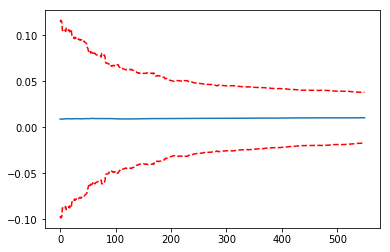

In [374]:
plt.plot(parameters_lab[50:600,1])
plt.plot(parameters_lab[50:600,1]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,1]+stderr_lab[50:600,0],'r--')
plt.show()

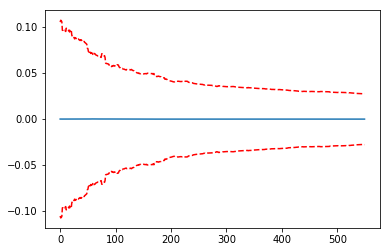

In [375]:
plt.plot(parameters_lab[50:600,2])
plt.plot(parameters_lab[50:600,2]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,2]+stderr_lab[50:600,0],'r--')
plt.show()

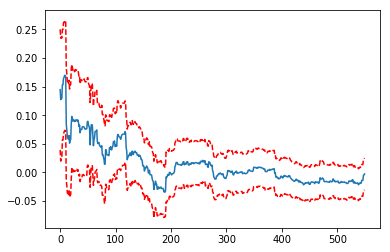

In [376]:
plt.plot(parameters_lab[50:600,3])
plt.plot(parameters_lab[50:600,3]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,3]+stderr_lab[50:600,0],'r--')
plt.show()

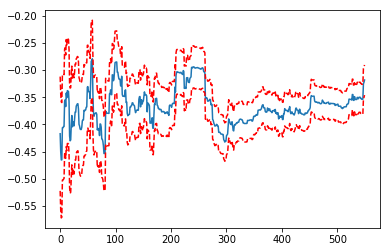

In [377]:
plt.plot(parameters_lab[50:600,4])
plt.plot(parameters_lab[50:600,4]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,4]+stderr_lab[50:600,0],'r--')
plt.show()

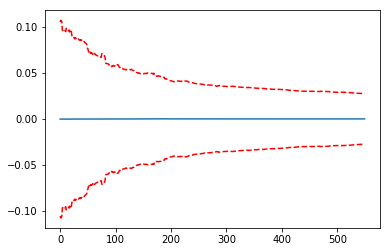

In [378]:
plt.plot(parameters_lab[50:600,5])
plt.plot(parameters_lab[50:600,5]-stderr_lab[50:600,0],'r--')
plt.plot(parameters_lab[50:600,5]+stderr_lab[50:600,0],'r--')
plt.show()

In [144]:
tweets

year  month  date   time            tweet_id  \
0    2017      6     9  20.26  873275224090980352   
1    2017      6     9  20.23  873274411654238209   
2    2017      6     9  16.44  873219358939590656   
3    2017      6     9  15.14  873196528923533312   
4    2017      6     9   9.40  873112674753630212   
5    2017      6     9   9.40  873112632907018240   
6    2017      6     9   9.38  873112128621641729   
7    2017      6     9   8.59  873102302113964033   
8    2017      6     9   8.49  873099783061164033   
9    2017      6     9   8.31  873095205984944129   
10   2017      6     9   8.27  873094155068555266   
11   2017      6     9   8.21  873092686340792320   
12   2017      6     9    8.6  873088948326744064   
13   2017      6     9    8.6  873088906438131712   
14   2017      6     9   7.43  873083195981406208   
15   2017      6     9   6.40  873067330468585472   
16   2017      6     9   6.40  873067288898879488   
17   2017      6     9   6.18  873061826765799425   
18   2017      6     9   6.13  873060566402596864   
19   2017      6     9   6.10  873059600412442626   
20   2017      6     9    6.9  873059517029695489   
21   2017      6     9    6.9  873059434271883265   
22   2017      6     9    6.8  873059306941202433   
23   2017      6     9    6.8  873059265413472257   
24   2017      6     9   5.55  873055822028324864   
25   2017      6     9   5.53  873055442963841024   
26   2017      6     9   5.46  873053678785011714   
27   2017      6     9   5.45  873053511138680834   
28   2017      6     9   5.40  873052209054851074   
29   2017      6     9   5.39  873051957304344578   
..    ...    ...   ...    ...                 ...   
705  2017      6     9    0.9  872968892133650432   
706  2017      6     9    0.8  872968682217107457   
707  2017      6     9    0.8  872968640185937924   
708  2017      6     8  23.57  872965743318618117   
709  2017      6     8  23.52  872964528023240704   
710  2017      6     8  23.51  872964356388139009   
711  2017      6     8  23.47  872963222952869888   
712  2017      6     8  23.44  872962466468253697   
713  2017      6     8  23.43  872962259638792192   
714  2017      6     8  23.41  872961921045102594   
715  2017      6     8  23.41  872961794834354178   
716  2017      6     8  23.36  872960660124160002   
717  2017      6     8  23.35  872960198465466368   
718  2017      6     8  23.27  872958183081463808   
719  2017      6     8  23.25  872957846215962625   
720  2017      6     8  23.17  872955663739179008   
721  2017      6     8  23.14  872955075349688321   
722  2017      6     8   23.7  872953144644423680   
723  2017      6     8   23.4  872952431352700930   
724  2017      6     8  22.58  872951044153761794   
725  2017      6     8  22.57  872950623737720832   
726  2017      6     8  22.56  872950582687956993   
727  2017      6     8  22.46  872947893551984641   
728  2017      6     8  22.46  872947852808466432   
729  2017      6     8  22.11  872939200991174657   
730  2017      6     8  22.10  872938948703682562   
731  2017      6     8   22.1  872936680088625153   
732  2017      6     8   22.1  872936640787992576   
733  2017      6     8  21.55  872935087352008704   
734  2017      6     6  17.27  872142809595293696   

                                                 tweet  
0    b'All the votes are counted, all the results a...  
1    b'Kensington: LAB win #GE2017. Full results: h...  
2    b'CORRECTION: Updated figures Southend West, C...  
3    b'Update: Correcting LAB number of votes. Winc...  
4    b'Update 10:40am: Latest seat totals by party ...  
5    b'Updated result: Wells, CON hold #GE2017. See...  
6    b'CORRECTION: Updated image Redditch CON hold ...  
7    b'Update 9:59am: Latest seat totals by party #...  
8    b'Update 9:49am: Latest seat totals by party #...  
9    b'Update 9:31am: Latest seat totals by party #...  
10   b'South East Cornwall: CON hold #GE2017. Full ...  
11   b'Update 9:21am: Latest seat 

In [111]:
np.matmul(param_lab,np.array(predict_lab).T).shape

(50, 550)

In [125]:
        param_lab = np.random.multivariate_normal(np.asarray(model_lab.params), RegressionResults.cov_params(model_lab), sim_num)
        predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
        
        
        #fill NaN with mean
        predict_lab = predict_lab.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_lab,np.array(predict_lab).T)
        #result_lab = np.random.normal(result_temp,np.std(model_lab.resid))
        err_sim = np.std(model_lab.resid)*(np.random.chisquare(len(model_lab.resid)-6, \
                                                               sim_num*result_temp.shape[1])*1./(len(model_lab.resid)-2))**0.5
        result_lab = result_temp + np.reshape(err_sim, (result_temp.shape[0],result_temp.shape[1]))

In [126]:
result_temp

array([[ 0.47604964,  0.63235269,  0.55420338, ...,  0.40788691,
         0.40788691,  0.28123695],
       [ 0.47830478,  0.6415956 ,  0.55834096, ...,  0.40432092,
         0.40432092,  0.28303655],
       [ 0.47064929,  0.62730506,  0.54903643, ...,  0.4019938 ,
         0.4019938 ,  0.2741433 ],
       ..., 
       [ 0.49132723,  0.63534127,  0.56643803, ...,  0.40665956,
         0.40665956,  0.28185357],
       [ 0.458902  ,  0.65069716,  0.54672501, ...,  0.40745234,
         0.40745234,  0.27160021],
       [ 0.45870987,  0.6417453 ,  0.54460752, ...,  0.40903881,
         0.40903881,  0.28099061]])

In [148]:
datetime.strptime('2018/1/26/10.3','%Y/%m/%d/%H.%M')

datetime.datetime(2018, 1, 26, 10, 3)

In [183]:
full_table[full_table['Con_poll']==np.nan]

Empty DataFrame
Columns: [ID, Constituency, Cnty, Rgn, Last Election, Party, Votes, Share, Majrty, turnout, Con[b], Lab[c], LD, SNP, UKIP, Grn[d], DUP, SF, PC, SDLP, UUP, APNI, Other[e], Total, time_full, time, Con_poll, Lab_poll, Lib_poll, SNP_poll, Pla_poll, Greens_poll, UKIP_poll, Other_poll, Seat, Region, 2015]
Index: []

[0 rows x 37 columns]

In [179]:
results

ID               Constituency Cnty  Rgn Last Election Party  \
0    W07000049                   Aberavon  WGM  WLS           Lab   Lab   
1    W07000058                  Aberconwy  CON  WLS           Con   Con   
2    S14000001             Aberdeen North  SCT  SCT           SNP   SNP   
3    S14000002             Aberdeen South  SCT  SCT           SNP   Con   
4    S14000003         Airdrie and Shotts  SCT  SCT           SNP   SNP   
5    E14000530                  Aldershot  HAM   SE           Con   Con   
6    E14000531        Aldridge-Brownhills  WMD   WM           Con   Con   
7    E14000532   Altrincham and Sale West  GTM   NW           Con   Con   
8    W07000043           Alyn and Deeside  CON  WLS           Lab   Lab   
9    E14000533               Amber Valley  DBY   EM           Con   Con   
10   S14000004                      Angus  SCT  SCT           SNP   Con   
11   W07000057                      Arfon  GWN  WLS            PC    PC   
12   S14000005            Argyll and Bute  SCT  SCT           SNP   SNP   
13   E14000534    Arundel and South Downs  WSX   SE           Con   Con   
14   E14000535                   Ashfield  NTT   EM           Lab   Lab   
15   E14000536                    Ashford  KEN   SE           Con   Con   
16   E14000537          Ashton-under-Lyne  GTM   NW           Lab   Lab   
17   E14000538                  Aylesbury  BKM   SE           Con   Con   
18   S14000006   Ayr, Carrick and Cumnock  SCT  SCT           SNP   Con   
19   E14000539                    Banbury  OXF   SE           Con   Con   
20   S14000007           Banff and Buchan  SCT  SCT           SNP   Con   
21   E14000540                    Barking  LND  LND           Lab   Lab   
22   E14000541           Barnsley Central  SYK  YTH           Lab   Lab   
23   E14000542              Barnsley East  SYK  YTH           Lab   Lab   
24   E14000543         Barrow and Furness  CMA   NW           Lab   Lab   
25   E14000544    Basildon and Billericay  ESS    E           Con   Con   
26   E14000545                Basingstoke  HAM   SE           Con   Con   
27   E14000546                  Bassetlaw  NTT   EM           Lab   Lab   
28   E14000547                       Bath  AVN   SW           Con    LD   
29   E14000548            Batley and Spen  WYK  YTH           Lab   Lab   
..         ...                        ...  ...  ...           ...   ...   
620  E14001035        West Worcestershire  HWR   WM           Con   Con   
621  E14001036          Westminster North  LND  LND           Lab   Lab   
622  E14001037   Westmorland and Lonsdale  CMA   NW            LD    LD   
623  E14001038          Weston-Super-Mare  AVN   SW           Con   Con   
624  E14001039                      Wigan  GTM   NW           Lab   Lab   
625  E14001040                  Wimbledon  LND  LND           Con   Con   
626  E14001041                 Winchester  HAM   SE           Con   Con   
627  E14001042                    Windsor  BRK   SE           Con   Con   
628  E14001043               Wirral South  MSY   NW           Lab   Lab   
629  E14001044                Wirral West  MSY   NW           Lab   Lab   
630  E14001045                     Witham  ESS    E           Con   Con   
631  E14001046                     Witney  OXF   SE           Con   Con   
632  E14001047                     Woking  SRY   SE           Con   Con   
633  E14001048                  Wokingham  BRK   SE           Con   Con   
634  E14001049   Wolverhampton North East  WMD   WM           Lab   Lab   
635  E14001050   Wolverhampton South East  WMD   WM           Lab   Lab   
636  E14001051   Wolverhampton South West  WMD   WM           Lab   Lab   
637  E14001052                  Worcester  HWR   WM           Con   Con   
638  E14001053                 Workington  CMA   NW           Lab   Lab   
639  E14001054   Worsley and Eccles South  GTM   NW           Lab   Lab   
640  E14001055              Worthing West  WSX   SE           Con   Con   
641  W07000044                    Wre

In [186]:
UKpoll

ID  Con_poll  Lab_poll  Lib_poll  SNP_poll  Pla_poll  Greens_poll  \
0    E14000530        55        22         9         0         0            2   
1    E14000531        65        27         5         0         0            0   
2    E14000532        59        27        12         0         0            2   
3    E14000533        57        36         4         0         0            2   
4    E14000534        63        16         9         0         0            2   
5    E14000535        35        38        10         0         0            1   
6    E14000536        56        22         7         0         0            1   
7    E14000537        29        50         3         0         0            1   
8    E14000538        53        20        10         0         0            2   
9    E14000539        56        24         8         0         0            1   
10   E14000540        22        53         3         0         0            1   
11   E14000541        24        52         4         0         0            0   
12   E14000542        23        51         5         0         0            0   
13   E14000543        47        40         4         0         0            1   
14   E14000544        54        25         5         0         0            0   
15   E14000545        52        28         7         0         0            0   
16   E14000546        47        47         4         0         0            0   
17   E14000547        40        17        37         0         0            6   
18   E14000548        44        46         6         0         0            4   
19   E14000549        50        37         9         0         0            1   
20   E14000550        65        16         9         0         0            1   
21   E14000551        67        24         6         0         0            3   
22   E14000552        51        40         5         0         0            3   
23   E14000553        19        39        36         0         0            2   
24   E14000554        59        17        22         0         0            3   
25   E14000555        19        59         7         0         0            7   
26   E14000556        58        29         8         0         0            4   
27   E14000557        58        19         8         0         0            2   
28   E14000558        49        28         3         0         0            1   
29   E14000559        26        67         4         0         0            2   
..         ...       ...       ...       ...       ...       ...          ...   
602  S14000030        16        33         2        47         0            0   
603  S14000031        19        30         3        44         0            3   
604  S14000032        15        34         2        48         0            0   
605  S14000033        19        30         3        47         0            0   
606  S14000034        20        29         2        47         0            0   
607  S14000035        15        34         2        47         0            0   
608  S14000036        18        30         2        50         0            0   
609  S14000037        25        11        24        39         0            0   
610  S14000038        20        31         2        47         0            0   
611  S14000039        20        13        24        41         0            0   
612  S14000040        22        29         2        47         0            0   
613  S14000041        20        32         2        44         0            0   
614  S14000042        25        29         2        42         0            0   
615  S14000043        22        31         2        45         0            0   
616  S14000044        21        29         2        48         0            0   
617  S14000045        22        30         3        43         0            0   
618  S14000046        40        14         4        40         0            0   
619  S14000047        18        32         

In [190]:
full_table[np.isnan(full_table.Lab_poll)]

ID                           Constituency Cnty  Rgn Last Election  \
21   N06000013                             North Down  NIR  NIR           Ind   
30   N06000016                             Strangford  NIR  NIR           DUP   
31   N06000009                           Lagan Valley  NIR  NIR           DUP   
87   N06000006                       East Londonderry  NIR  NIR           DUP   
106  N06000004                           Belfast West  NIR  NIR            SF   
135  N06000014                           South Antrim  NIR  NIR           UUP   
164  N06000012                           North Antrim  NIR  NIR           DUP   
213  N06000001                           Belfast East  NIR  NIR           DUP   
235  N06000005                            East Antrim  NIR  NIR           DUP   
263  N06000002                          Belfast North  NIR  NIR           DUP   
287  N06000015                             South Down  NIR  NIR          SDLP   
348  N06000017                             Upper Bann  NIR  NIR           DUP   
371  N06000018                            West Tyrone  NIR  NIR            SF   
380  N06000011                       Newry and Armagh  NIR  NIR            SF   
433  N06000007             Fermanagh and South Tyrone  NIR  NIR           UUP   
486  N06000008                                  Foyle  NIR  NIR          SDLP   
562  N06000010                             Mid Ulster  NIR  NIR            SF   
564  N06000003                          Belfast South  NIR  NIR          SDLP   
646        NaN  Sheffield Brightside and Hillsborough  SYK  YTH           Lab   
647        NaN                       Sheffield Hallam  SYK  YTH            LD   
648        NaN                       Sheffield Heeley  SYK  YTH           Lab   

    Party   Votes   Share  Majrty turnout  ...   Lab_poll  Lib_poll  SNP_poll  \
21    Ind  16,148  41.20%   1,208  60.90%  ...        NaN       NaN       NaN   
30    DUP  24,036  62.00%  18,343  60.20%  ...        NaN       NaN       NaN   
31    DUP  26,762  59.60%  19,229  62.10%  ...        NaN       NaN       NaN   
87    DUP  19,723  48.10%   8,842  61.20%  ...        NaN       NaN       NaN   
106    SF  27,107  66.70%  21,652  65.10%  ...        NaN       NaN       NaN   
135   DUP  16,508  38.20%   3,208  63.30%  ...        NaN       NaN       NaN   
164   DUP  28,521  58.90%  20,643  64.10%  ...        NaN       NaN       NaN   
213   DUP  23,917  55.80%   8,474  67.50%  ...        NaN       NaN       NaN   
235   DUP  21,873  57.30%  15,923  60.60%  ...        NaN       NaN       NaN   
263   DUP  21,240  46.20%   2,081  67.30%  ...        NaN       NaN       NaN   
287    SF  20,328  39.90%   2,446  67.20%  ...        NaN       NaN       NaN   
348   DUP  22,317  43.50%   7,992  63.90%  ...        NaN       NaN       NaN   
371    SF  22,060  50.70%  10,342  67.90%  ...        NaN       NaN       NaN   
380    SF  25,666  47.90%  12,489  68.50%  ...        NaN       NaN       NaN   
433    SF  25,230  47.20%     875  75.80%  ...        NaN       NaN       NaN   
486    SF  18,256  39.70%     169  65.40%  ...        NaN       NaN       NaN   
562    SF  25,455  54.50%  12,890  68.20%  ...        NaN       NaN       NaN   
564   DUP  13,299  30.40%   1,996  66.10%  ...        NaN       NaN       NaN   
646   Lab  28,193  67.30%  19,143  59.50%  ...        NaN       NaN       NaN   
647   Lab  21,881  38.40%   2,125  77.60%  ...        NaN       NaN       NaN   
648   Lab  26,524  60.00%  13,828  65.00%  ...        NaN       NaN       NaN   

     Pla_poll  Greens_poll  UKIP_poll  Other_poll  Seat  Region  2015  
21        NaN          NaN        NaN         NaN   NaN     NaN   NaN  
30        NaN          NaN        NaN         NaN   NaN     NaN   NaN  
31        NaN          NaN        NaN         NaN   NaN     NaN   NaN  
87        NaN          NaN        NaN         NaN   NaN     NaN   NaN  
106       NaN          NaN        NaN         NaN   NaN     NaN   NaN  
135       NaN 

In [199]:
full_table[np.bitwise_and(np.isnan(full_table.Con_poll),full_table['Last Election']=="Con")]

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [222]:
len(full_table[np.isnan(full_table.Con_poll)])

21

In [274]:
a=full_table[full_table['ID']=='E14000955']

In [284]:
full_table[['Lab[c]','Lab_poll']]

Lab[c]  Lab_poll
0    0.648919      53.0
1    0.594624      53.0
2    0.555430      49.0
3    0.675529      49.0
4    0.384185      29.0
5    0.607261      53.0
6    0.553533      45.0
7    0.365436      28.0
8    0.412790      35.0
9    0.656733      54.0
10   0.288997      21.0
11   0.311256      25.0
12   0.511493      42.0
13   0.615079      51.0
14   0.506080      43.0
15   0.651280      54.0
16   0.534629      45.0
17   0.488801      48.0
18   0.435821      35.0
19   0.375472      34.0
20   0.200828      18.0
21        NaN       NaN
22   0.568767      47.0
23   0.325149      26.0
24   0.562081      51.0
25   0.622082      53.0
26   0.596414      44.0
27   0.601815      57.0
28   0.729331      60.0
29   0.768568      67.0
..        ...       ...
620  0.519194      40.0
621  0.096265      12.0
622  0.795532      69.0
623  0.212760      17.0
624  0.234670      18.0
625  0.217893      19.0
626  0.268450      18.0
627  0.182825      16.0
628  0.318395      31.0
629  0.702625      59.0
630  0.091157      18.0
631  0.456885      35.0
632  0.425760      38.0
633  0.481821      40.0
634  0.464919      40.0
635  0.142467      16.0
636  0.289862      18.0
637  0.226402      16.0
638  0.422292      33.0
639  0.471187      35.0
640  0.758347      56.0
641  0.250016      18.0
642  0.594987      52.0
643  0.120740      13.0
644  0.426286      32.0
645  0.259373      19.0
646  0.673346       NaN
647  0.383743       NaN
648  0.599738       NaN
649  0.285135      22.0

[650 rows x 2 columns]

In [285]:
a['Lab_poll']

581   NaN
Name: SNP, dtype: float64

In [348]:
    i=580
    data_lab= pd.concat([full_table['Lab_poll'], full_table['WageMedianConst'],full_table['islab'],\
                      full_table['Pop65ConstRate'],full_table['islab']*full_table['WageMedianConst'],\
                     full_table['islab']*full_table['Pop65ConstRate'],full_table['Lab[c]']], axis=1)
    X_lab = data_lab.drop('Lab[c]',axis=1)[0:i]
    Y_lab=data_lab['Lab[c]'][0:i]
    X_lab=sm.add_constant(X_lab, has_constant='add')
    model_lab = sm.OLS(Y_lab, X_lab,missing = 'drop').fit()
    
    
    #Conservatives regression
    #data_con=full_table[['Con_poll','Con[b]','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_con=pd.concat([full_table['Con_poll'], full_table['WageMedianConst'], full_table['iscon'],
                     full_table['Pop65ConstRate'],  full_table['iscon']*full_table['WageMedianConst'],
                      full_table['iscon']*full_table['Pop65ConstRate'],full_table['Con[b]']], axis=1)
    X_con = data_con.drop(['Con[b]'], axis = 1)[0:i]
    Y_con=data_con['Con[b]'][0:i]
    X_con=sm.add_constant(X_con, has_constant='add')
    model_con = sm.OLS(Y_con, X_con,missing = 'drop').fit()
    
    parameters_con[i,:]=model_con.params
    
    #Liberal Regression
    #data_lib=full_table[['Lib_poll','LD','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    #data_lib=pd.concat([full_table['Lib_poll'], full_table['WageMedianConst'],full_table['islib'],
    #                 full_table['Pop65ConstRate'],full_table['islib']* full_table['WageMedianConst'],
    #                full_table['islib']*full_table['Pop65ConstRate'],full_table['LD']], axis=1)
    #X_lib = data_lib.drop(['LD'],axis=1)[0:i]
    #Y_lib=data_lib['LD'][0:i]
    #X_lib=sm.add_constant(X_lib, has_constant='add')
    #model_lib = sm.OLS(Y_lib, X_lib,missing = 'drop').fit()
    

    #SNP Regression
    #SNP has no votes and poll in many regions, assign 0 to model in this case
    #full_table['SNP']=full_table['SNP'].fillna(0)
    #data_snp=full_table[['SNP_poll','SNP','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    data_snp=pd.concat([full_table['SNP_poll'], full_table['WageMedianConst'],
                     full_table['Pop65ConstRate'], full_table['SNP']], axis=1)
    #data_snp = data_snp[data_snp.SNP_poll!=0]
    X_snp = data_snp.drop(['SNP'],axis = 1)[0:i]
    Y_snp = data_snp['SNP'][0:i]
    X_snp=sm.add_constant(X_snp, has_constant='add')
    try:
        model_snp = sm.OLS(Y_snp, X_snp,missing = 'drop').fit()
    except:
        model_snp = 0
        

    

    predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
    predict_lab=predict_lab[np.isfinite(predict_lab['Lab_poll'])]
    result = np.zeros([sim_num, len(predict_lab)])
    
    #Sampling the regression parameters to generate predicted outcome
    for j in range(0, sim_num):
        
        #Labour
        param_lab = np.random.multivariate_normal(np.asarray(model_lab.params), RegressionResults.cov_params(model_lab), sim_num)
        predict_lab=sm.add_constant(data_lab.drop('Lab[c]',axis=1)[i:], has_constant='add')
        
        
        #fill NaN with mean
        #predict_lab = predict_lab.fillna(predict_lab.mean())
        predict_lab=predict_lab[np.isfinite(predict_lab['Lab_poll'])]
        
        result_temp =  np.matmul(param_lab,np.array(predict_lab).T)
        #result_lab = np.random.normal(result_temp,np.std(model_lab.resid))
        err_dev = np.std(model_lab.resid)*(np.random.chisquare(len(model_lab.resid)-7)*1./(len(model_lab.resid)-7))**0.5
        result_lab = np.random.normal(result_temp,err_dev)
        
        
        #Conservative
        param_con = np.random.multivariate_normal(np.asarray(model_con.params), RegressionResults.cov_params(model_con), sim_num)
        predict_con=sm.add_constant(data_con.drop(['Con[b]'], axis = 1)[i:], has_constant='add')
        
        
        #predict_con = predict_con.fillna(predict_con.mean())
        predict_con = predict_con[np.isfinite(predict_con['Con_poll'])]
        
        result_temp = np.matmul(param_con,np.array(predict_con).T)
        #result_con = np.random.normal(result_temp,np.std(model_con.resid))
        err_dev = np.std(model_con.resid)*(np.random.chisquare(len(model_con.resid)-7)*1./(len(model_con.resid)-7))**0.5
        result_con = np.random.normal(result_temp,err_dev)
        
        
        #Liberal
        #param_lib = np.random.multivariate_normal(np.asarray(model_lib.params), RegressionResults.cov_params(model_lib), sim_num)
        #predict_lib=sm.add_constant(data_lib.drop(['LD'],axis=1)[i:], has_constant='add')
        
        
        #predict_lib = predict_lib.fillna(predict_lib.mean())
        
        #result_temp =  np.matmul(param_lib,np.array(predict_lib).T)
        #err_dev = np.std(model_lib.resid)*(np.random.chisquare(len(model_lib.resid)-7)*1./(len(model_lib.resid)-2))**0.5
        #result_lib = np.random.normal(result_temp,err_dev)
        
        
        #SNP
        predict_snp=sm.add_constant(data_snp.drop(['SNP'],axis = 1)[i:], has_constant='add')
        predict_snp = predict_snp[np.isfinite(predict_snp['SNP_poll'])]
        if not model_snp==0 and len(model_snp.resid)>8:
            param_snp = np.random.multivariate_normal(np.asarray(model_snp.params), RegressionResults.cov_params(model_snp), sim_num)

            #predict_snp = predict_snp.fillna(predict_snp.mean())

            result_temp =  np.matmul(param_snp,np.array(predict_snp).T)
            #result_snp = np.random.normal(result_temp,np.std(model_snp.resid))
            err_dev = np.std(model_snp.resid)*(np.random.chisquare(len(model_snp.resid)-4)*1./(len(model_snp.resid)-4))**0.5
            result_snp = np.random.normal(result_temp,err_dev)
            #make all data poll 0 to 0
            ind = predict_snp.index[predict_snp.SNP_poll==0]
        else:
            #no data
            result_snp = np.tile(predict_snp['SNP_poll'],(sim_num,1))/100
        
        #result_pla = np.nan_to_num(np.tile(full_table['Pla_poll'][i:],(sim_num,1)))/100
        #result_ukip = np.nan_to_num(np.tile(full_table['UKIP_poll'][i:],(sim_num,1)))/100
        other = 1-result_con-result_lab-result_snp
        
        result_temp = (result_con>result_lab) & (result_con>result_snp) & (result_con>other)  
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
    EEV=len(full_table.Party[0:i][full_table.Party=='Con'])+ np.count_nonzero(result, axis=1) 

In [341]:
 model_snp = sm.OLS(Y_snp, X_snp[['const','SNP_poll','WageMedianConst','Pop65ConstRate','issnp','0']],missing = 'drop').fit()

KeyError: "['0'] not in index"

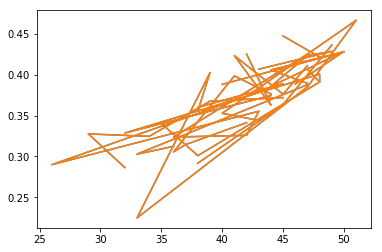

In [331]:
plt.plot(X_snp['SNP_poll'],Y_snp)
plt.show()